In [1]:
# Imports
%load_ext autoreload
%autoreload 2
import os
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

from dataloaders.bouncing_data import BouncingBallDataLoader
from utils.losses import kld_loss, nll_gaussian
from models.VRNN import VRNN


## Load data/sample

In [2]:
dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_square/train', False)
train_loader = torch.utils.data.DataLoader(dl, batch_size=16, shuffle=True)
im, pos = next(iter(train_loader))
print(im.size(), pos.size())

torch.Size([16, 100, 3, 32, 32]) torch.Size([16, 100, 2])


## Pos

### Load model

In [3]:
vrnn = VRNN(3, 2, 256, 64, num_rec_layers=3, input_type='base').float()
print(vrnn)
checkpoint = torch.load('/data2/users/cb221/stored_models/VRNN_pos_conditional_prior_box_lstm_big_latest.pth.tar', map_location=torch.device('cpu'))
vrnn.load_state_dict(checkpoint['vrnn'])

VRNN(
  (prior): MLP(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=128, bias=True)
  )
  (embedder_x): MLP(
    (fc1): Linear(in_features=2, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=64, bias=True)
  )
  (decoder): MLP(
    (fc1): Linear(in_features=320, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=2, bias=True)
  )
  (encoder): MLP(
    (fc1): Linear(in_features=320, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=128, bias=True)
  )
  (embedder_z): MLP(
    (fc1): Linear(in_features=64, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out

<All keys matched successfully>

### Seq Autoencode

tensor(3.9346e-06, dtype=torch.float64, grad_fn=<MseLossBackward>)

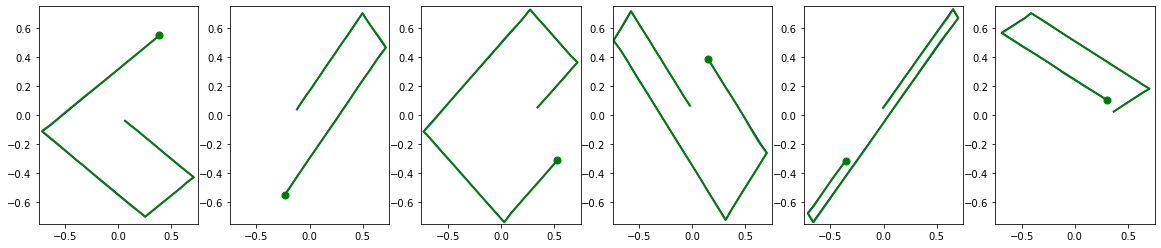

In [5]:
reconstr, _, _ = vrnn(pos[:,:50].float())
print(reconstr.size())
plt.figure(figsize=(20,4))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.plot(pos[i,:50,0].detach(),pos[i,:50,1].detach(), 'b')
    plt.plot(reconstr[i,:50,0].detach(),reconstr[i,:50,1].detach(), 'g', linewidth=2)
    plt.scatter(reconstr[i,-1,0].detach(),reconstr[i,-1,1].detach(), s=50,c='g')
    plt.xlim(-0.75,0.75)
    plt.ylim(-0.75,0.75)
F.mse_loss(reconstr,pos[:,:50])

### Seq prediction

In [6]:
T=50
pred_pos = vrnn.predict_sequence(pos[:,:50].float(),seq_len=T)
print(pred_pos.size())
target_pos = pos[:,50:50+T].float().to(pred_pos.device)
pred_mse = F.mse_loss(pred_pos, target_pos)
print(pred_mse)

torch.Size([16, 50, 2])
tensor(0.0058, grad_fn=<MseLossBackward>)


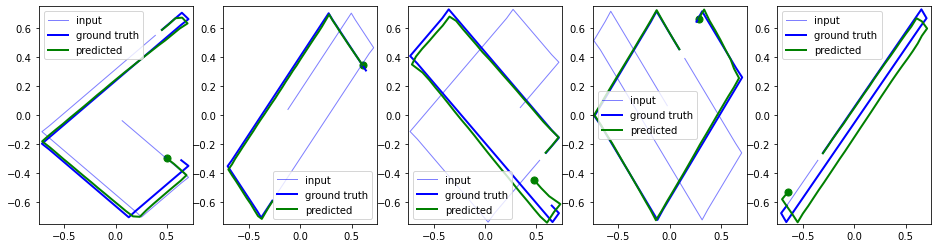

In [7]:
plt.figure(figsize=(16,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(pos[i,50-T:50,0].detach(),pos[i,50-T:50,1].detach(), 'b', linewidth=1, alpha=0.5, label='input')
    plt.plot(pos[i,50:50 + T,0].detach(),pos[i,50:50 + T,1].detach(), 'b', linewidth=2, alpha=1, label='ground truth')
    plt.plot(pred_pos[i,:T,0].detach(),pred_pos[i,:T,1].detach(), 'g', linewidth=2, label='predicted')
    plt.scatter(pred_pos[i,-1,0].detach(),pred_pos[i,-1,1].detach(), s=50,c='g')
    plt.xlim(-0.75,0.75)
    plt.ylim(-0.75,0.75)
    plt.legend()

### Seq Generation

In [9]:
b = 16
h_prev = torch.zeros((3, b, vrnn.hidden_dim))
c_prev = torch.zeros((3, b, vrnn.hidden_dim))
pred_seq = torch.zeros((b, 100, 2))
for i in range(50):
    z_sampled = vrnn._sample(h_prev)
    x_hat, h_prev, c_prev = vrnn._decode(z_sampled, h_prev, c_prev)
    pred_seq[:,i,:] = x_hat

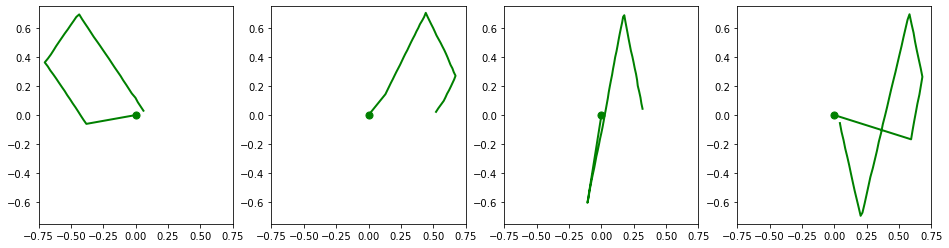

In [10]:
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(pred_seq[i,:100,0].detach(),pred_seq[i,:100,1].detach(), 'g', linewidth=2)
    plt.scatter(pred_seq[i,-1,0].detach(),pred_seq[i,-1,1].detach(), s=50,c='g')
    plt.xlim(-.75,.75)
    plt.ylim(-.75,.75)

## Image

### Load model

In [3]:
vrnn = VRNN(3, 2, 256, 64, num_rec_layers=3, input_type='visual').float()
print(vrnn)
checkpoint = torch.load('/data2/users/cb221/stored_models/VRNN_visual_square_beta_0_005_latest.pth.tar', map_location=torch.device('cpu'))
vrnn.load_state_dict(checkpoint['vrnn'])

VRNN(
  (prior): MLP(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=128, bias=True)
  )
  (embedder_x): CNNEncoder(
    (in_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (hidden_conv): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (out_conv): Conv2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (out_mean): MLP(
      (fc1): Linear(in_features=256, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (fc_final): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (decoder

<All keys matched successfully>

### Sequence Autoencode

/data2/packages/anaconda3/envs/py38_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


torch.Size([16, 50, 3, 32, 32])
tensor(2.7497e-06, dtype=torch.float64, grad_fn=<MseLossBackward>)


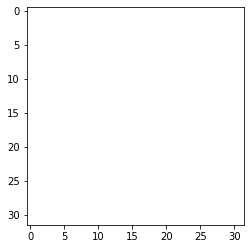

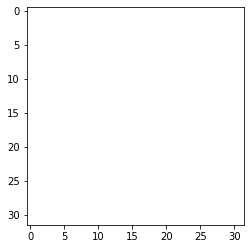

In [17]:
reconstr, _, _ = vrnn(im[:,:50].float())
print(reconstr.size())
print(F.mse_loss(reconstr,im[:,:50]))
reconstr = reconstr.detach().numpy().transpose((0,1,4,3,2))
im_np = im.detach().numpy().transpose((0,1,4,3,2))
def get_frames(frames_np):
    fig, ax = plt.subplots()
    ims = []
    for i in range(50):
        im_ax = ax.imshow(frames_np[i], animated=True)
        ims.append([im_ax])
    return fig, ims
fig_pred, ims_pred = get_frames(reconstr[0])
ani_pred = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
fig_true, ims_true = get_frames(im_np[0])
ani_true = animation.ArtistAnimation(fig_true, ims_true, interval=50, blit=True,
                                repeat_delay=1000)

In [18]:
HTML(ani_pred.to_html5_video())

In [19]:
HTML(ani_true.to_html5_video())

### Sequence Prediction

torch.Size([16, 50, 3, 32, 32])
tensor(0.0019, grad_fn=<MseLossBackward>)


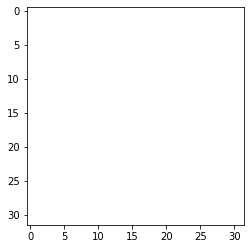

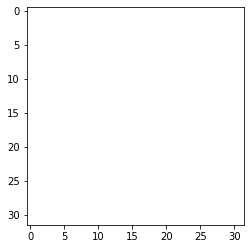

In [38]:
T=50
pred_ = vrnn.predict_sequence(im[:,:50].float(),seq_len=T)
print(pred_.size())
target_ = im[:,50:50+T].float().to(pred_.device)
pred_mse = F.mse_loss(pred_, target_)
print(pred_mse)
fig_pred, ims_pred = get_frames(pred_[0].detach().numpy().transpose((0,3,2,1)))
ani_pred = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
fig_true, ims_true = get_frames(target_[0].detach().numpy().transpose((0,3,2,1)))
ani_true = animation.ArtistAnimation(fig_true, ims_true, interval=50, blit=True,
                                repeat_delay=1000)

In [39]:
HTML(ani_pred.to_html5_video())

In [40]:
HTML(ani_true.to_html5_video())

### Sequence Sampling

In [35]:
b = 1
h_prev = torch.zeros((3, b, vrnn.hidden_dim))
c_prev = torch.zeros((3, b, vrnn.hidden_dim))
pred_seq = torch.zeros((b, 50, 3, 32, 32))
for i in range(50):
    z_sampled = vrnn._sample(h_prev)
    x_hat, h_prev, c_prev = vrnn._decode(z_sampled, h_prev, c_prev)
    pred_seq[:,i,:] = x_hat

/data2/packages/anaconda3/envs/py38_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


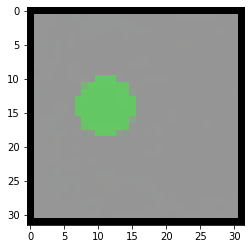

In [36]:
fig_pred, ims_pred = get_frames(pred_seq[0].detach().numpy().transpose((0,3,2,1)))
ani_sample = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani_sample.to_html5_video())